In [1]:
#
# This is an example from jbr Reactor Design Book
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm_red.m
#

Reduced order model with states $V, \epsilon_2$:
$$\frac{dV}{dt} = Q^{in}_B(t)$$
$$\frac{d\epsilon_2}{dt} = \frac{Q^{in}_B(t)c_{Bf}(n^{added}_B-2\epsilon_2)}{(n^{added}_B-2\epsilon_2) + k(n_{A0} - n^{added}_B + \epsilon_2)} $$ 

Calculation of $n_B^{added}$:
$$ n_B^{added} = (V - V(0))c_{Bf} $$

Parameters:
$k = 2.48, \;\;n_{A0} = 2.35$

Initial conditions:
$V = 2370, \;\;\epsilon_2 = 0$

In [2]:
from kipet import KipetModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

    Set objects from pyomo.core.base.set or pyomo.core.  (deprecated in 5.7)
    (called from <frozen importlib._bootstrap>:219)
_SetProduct not found


In [3]:
# Import data set with flow of B over time
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/flow.dat'
flow_df = pd.read_csv(filename, delimiter=r"\s+", header = None)
flow_df.columns = ['time', 'Qf', 'x']
flow_df['qin_B'] = flow_df['Qf'] / 0.728
flow_df = flow_df.set_index('time')
qinB_traj = flow_df[['qin_B']]
qinB_traj

,qin_B
time,
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319
49.0,1.669967
...,...
829.0,0.000990
839.0,0.000782
849.0,0.000643


In [4]:
# insert first row for time 0
qinB_row0 = pd.DataFrame({'time':[0], 'qin_B':[0]}).set_index('time')
qinB_traj = qinB_traj.append(qinB_row0).sort_index()
qinB_traj.head()

,qin_B
time,
0.0,0.000000
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319


In [5]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/lc.dat'
lc_data = pd.read_csv(filename, delimiter=r"\s+", header = None)
lc_data.columns = ['time', 'y']
lc_data = lc_data.set_index('time')

In [6]:
lc_data.head()

,y
time,
414,0.1705
424,0.1604
434,0.1325
444,0.1084
493,0.1014


In [24]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('V', state = 'state', init = 2370)
r1.add_component('eps2', state = 'concentration', init = 0.0)
r1.add_component('qin_B', state = 'trajectory')

r1.add_algebraic_variables(['qin_B', 'nBadded', 'y1', 'y'])

r1.add_parameter('k', init = 2.48)
r1.add_parameter('na0', init = 2.34)

cbf = 0.00721
V0 = 2370

In [25]:
def rule_odes(m,t):
        
    exprs = dict()
    exprs['V'] = m.Y[t,'qin_B']
    exprs['eps2'] = m.Y[t, 'y1']
    return exprs

r1.add_equations(rule_odes) 

In [26]:
def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t,'nBadded'] - (m.X[t, 'V'] - V0) * cbf)
    r.append(m.Y[t,'y1'] * ((m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']) + m.P['k']*(m.P['na0'] - m.Y[t,'nBadded'] + m.Z[t, 'eps2'])) - m.Y[t,'qin_B'] * cbf * (m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']))
    r.append(m.Y[t, 'y'] * m.Y[t, 'nBadded'] - (m.Y[t,'nBadded'] - 2 * m.Z[t,'eps2']))
    return r

r1.add_algebraics(rule_algebraics)

In [27]:
r1.add_dataset('Traj', category = 'trajectory', data = qinB_traj)

In [28]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')
r1.set_times(0, 900)

In [29]:
#r1.settings.collocation.nfe = 60
#r1.settings.collocation.ncp = 1
#r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
r1.settings.solver.linear_solver = 'ma27'

In [30]:
r1.simulate()

times are: <class 'tuple'>
 If this is the desired behavior, some algebraics must be added after the model is created.


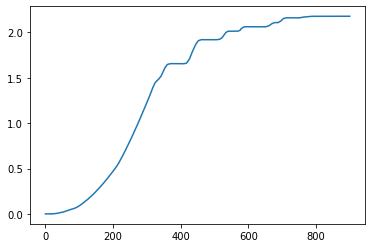

In [31]:
fig, ax = plt.subplots()
ax.plot(r1.results.Z.index, r1.results.Z['eps2'])

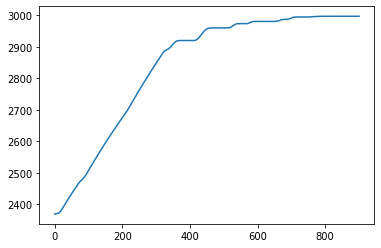

In [32]:
fig, ax = plt.subplots()
ax.plot(r1.results.X.index, r1.results.X['V'])

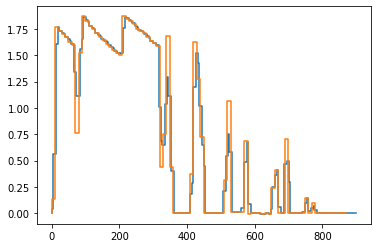

In [33]:
fig, ax = plt.subplots()
ax.step(r1.results.Y.index, r1.results.Y['qin_B'])
ax.step(qinB_traj.index, qinB_traj['qin_B'])

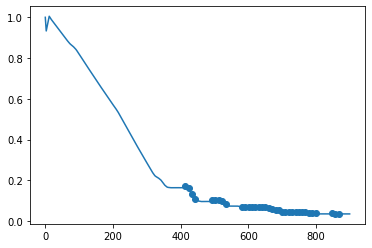

In [34]:
fig, ax = plt.subplots()
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(r1.results.Y.index, r1.results.Y['y'])

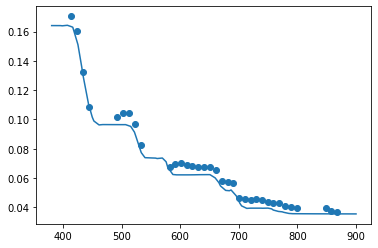

In [35]:
fig, ax = plt.subplots()
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(r1.results.Y.index[r1.results.Y.index >= 380], r1.results.Y['y'][r1.results.Y.index >= 380])